In [1]:
# import Pkg; Pkg.add("Missings")

In [2]:
using Random
Random.seed!(13)

using CSV
using Plots
using DataFrames
using Statistics
using Missings
using Distributions
using StatsPlots
using LowRankModels, LinearAlgebra

In [3]:
include("proxgrad.jl")
df = CSV.read("airline.csv")

,airline_name,link,title,author
,String,String,String,String
1,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,D Ito
2,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Ron Kuhlmann
3,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,E Albin
4,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Tercon Bojan
5,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,L James
6,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Dzano Edin
7,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,M Tushishvili
8,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,M Znidar
9,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Tercon Bojan


In [4]:
# Organize and display features along with variable type
feature_names = names(df)
for i in 1:20
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(df[!, i])))
end

1	airline_name			String
2	link			String
3	title			String
4	author			String
5	author_country			Union{Missing, String}
6	date			Dates.Date
7	content			String
8	aircraft			Union{Missing, String}
9	type_traveller			Union{Missing, String}
10	cabin_flown			Union{Missing, String}
11	route			Union{Missing, String}
12	overall_rating			Union{Missing, Float64}
13	seat_comfort_rating			Union{Missing, Float64}
14	cabin_staff_rating			Union{Missing, Float64}
15	food_beverages_rating			Union{Missing, Float64}
16	inflight_entertainment_rating			Union{Missing, Float64}
17	ground_service_rating			Union{Missing, Float64}
18	wifi_connectivity_rating			Union{Missing, Float64}
19	value_money_rating			Union{Missing, Float64}
20	recommended			Int64


In [5]:
# df = df[1:10000,:]

In [6]:
# Reduce number of datapoints for computation time

# Filter data to only consider entries with overall rating
df_OR = df[.!(ismissing.(df[!, :overall_rating])), :];

df_OR_filtered = df_OR[.!(ismissing.(df_OR[!, :seat_comfort_rating])), :]; 
data_OR_filtered = df_OR_filtered[.!(ismissing.(df_OR_filtered[!, :cabin_staff_rating])), :];

# Now adding food_beverages_rating, inflight_entertainment_rating, and value money rating
data_OR_filtered = data_OR_filtered[.!(ismissing.(data_OR_filtered[!, :food_beverages_rating])), :];
data_OR_filtered = data_OR_filtered[.!(ismissing.(data_OR_filtered[!, :inflight_entertainment_rating])), :];
data_OR_filtered = data_OR_filtered[.!(ismissing.(data_OR_filtered[!, :value_money_rating])), :];

train_proportion = 0.8
n = size(data_OR_filtered, 1)
println("Size of dataset: ", string(n))

# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
ntrain = convert(Int, round(train_proportion*n))
println("Size of train: ", string(round(train_proportion*n)))
println("Size of test: ", string(round(n-train_proportion*n)))

target = data_OR_filtered[:, :overall_rating]

# Filter data for entries with only seat_comfort, cabin_staff
# df_OR_filtered = df_OR[.!(ismissing.(df[!, :seat_comfort_rating])), :]; 
# df_OR_filtered = df_OR[.!(ismissing.(df[!, :cabin_staff_rating])), :]; 
# data_OR_filtered = df_OR_filtered[:, filter(col -> (col != :overall_rating), feature_names)]

# the following variable records the features of examples in the training set
train_x = data_OR_filtered[1:ntrain,:]

# the following variable records the features of examples in the test set
test_x = data_OR_filtered[ntrain+1:end,:]

# the following variable records the labels of examples in the training set
train_y = target[1:ntrain]
train_y = collect(skipmissing(train_y))
# the following variable records the labels of examples in the test set
test_y = target[ntrain+1:end]
test_y = collect(skipmissing(test_y));

Size of dataset: 28341
Size of train: 22673.0
Size of test: 5668.0


In [7]:
"""This function just computes the mean squared error."""
function MSE(y, pred)
    "Fill this in."
    num = size(y,1)
    error = sum(abs.((y.-pred).^2))/num
    return error
end

"""This function plots the main diagonal; 
for a "predicted vs true" plot with perfect predictions,
all data lies on this line"""
function plotDiagonal(xmin, xmax)
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color=:black)
end

"""This helper funciton plots x vs, y and labels the axes."""
function plotdata(x,y,xname, yname; margin=.05, plotDiag=true, zeromin=false)
    scatter(x,y, label="data")
    xlabel!(xname)
    ylabel!(yname)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x)-margin*range_x, maximum(x)+margin*range_x)
    end
    if zeromin
        ylims!((0.0,maximum(y)+margin*range_y))
        xlims!((0.0,maximum(x)+margin*range_x))
    else
        ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
        xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
    end
end

"""This function plots the predicted labels vs the actual labels
(We only plots the first 1000 points to avoid slow plots.)"""
function plot_pred_true(test_pred, test_y, max_points = 1000)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted Rating", "True Rating", zeromin=true)
end

plot_pred_true

In [8]:
"This function converts strings to floating point values.
Strings that cannot be represented as a number (like NA) are converted to zeros"
function string_to_float(str)
    try
        parse(Float64, str)
    catch
       0.0
    end
end

labels_real = [
  :overall_rating,
  :seat_comfort_rating,
  :cabin_staff_rating,
  :food_beverages_rating,
  :inflight_entertainment_rating,
  :ground_service_rating,
  :wifi_connectivity_rating,
  :value_money_rating,
  :recommended
]

labels_string = [
    :beds,
    :security_deposit,
    :cleaning_fee
]

3-element Array{Symbol,1}:
 :beds            
 :security_deposit
 :cleaning_fee    

In [9]:
# # Only converting for seat comfort and cabin staff
# train_vals_real = convert(Matrix,train_x[:,filter(col -> (col in labels_real), [:seat_comfort_rating,:cabin_staff_rating])]);
# test_vals_real = convert(Matrix,test_x[:,filter(col -> (col in labels_real), [:seat_comfort_rating,:cabin_staff_rating])]);
# size(train_vals_real,1)
# any(ismissing,train_vals_real)

# Only converting for seat comfort, cabin staff, food/beverage, and inflight entertainment
train_vals_real = convert(Matrix,train_x[:,filter(col -> (col in labels_real), [:seat_comfort_rating,:cabin_staff_rating,:food_beverages_rating,:inflight_entertainment_rating,:value_money_rating])]);
test_vals_real = convert(Matrix,test_x[:,filter(col -> (col in labels_real), [:seat_comfort_rating,:cabin_staff_rating,:food_beverages_rating,:inflight_entertainment_rating,:value_money_rating])]);
size(train_vals_real,1)
any(ismissing,train_vals_real)

# Add offset
train_vals_real = [train_vals_real ones(size(train_vals_real,1))];
test_vals_real = [test_vals_real ones(size(test_vals_real,1))];

[train_vals_real train_y]

22673×7 Array{Union{Missing, Float64},2}:
 4.0  4.0  4.0  0.0  4.0  1.0   7.0
 4.0  5.0  4.0  1.0  5.0  1.0  10.0
 5.0  5.0  4.0  0.0  5.0  1.0   9.0
 4.0  4.0  3.0  1.0  4.0  1.0   8.0
 4.0  2.0  1.0  2.0  2.0  1.0   4.0
 4.0  4.0  3.0  3.0  4.0  1.0   9.0
 4.0  4.0  1.0  0.0  3.0  1.0   5.0
 5.0  5.0  4.0  3.0  4.0  1.0   9.0
 4.0  3.0  4.0  1.0  4.0  1.0   8.0
 5.0  5.0  4.0  4.0  4.0  1.0  10.0
 4.0  4.0  4.0  4.0  4.0  1.0   9.0
 4.0  5.0  3.0  3.0  5.0  1.0   7.0
 4.0  4.0  4.0  0.0  4.0  1.0   8.0
 ⋮                        ⋮        
 1.0  1.0  1.0  1.0  1.0  1.0   1.0
 2.0  1.0  1.0  1.0  1.0  1.0   1.0
 1.0  2.0  1.0  1.0  1.0  1.0   1.0
 1.0  2.0  2.0  1.0  1.0  1.0   1.0
 2.0  4.0  3.0  1.0  2.0  1.0   2.0
 1.0  2.0  1.0  1.0  1.0  1.0   1.0
 1.0  1.0  1.0  1.0  1.0  1.0   1.0
 1.0  1.0  1.0  1.0  1.0  1.0   1.0
 1.0  1.0  1.0  1.0  1.0  1.0   1.0
 5.0  5.0  2.0  3.0  5.0  1.0  10.0
 2.0  4.0  2.0  1.0  3.0  1.0   6.0
 1.0  1.0  1.0  1.0  1.0  1.0   1.0

In [10]:
# Calculate w solution for "seat_comfort_rating" and "cabin_staff_rating"
w = train_vals_real\train_y

6-element Array{Float64,1}:
  0.4292222930742452  
  0.6601946292405828  
  0.17064976265521078 
  0.020942258166934246
  0.9576473792180102  
 -1.4686629460470595  

SEAT COMFORT RATING, CABIN STAFF RATING, FOOD/BEVERAGE, INFLIGHT ENTERTAINMENT, VALUE MONEY RATING
Train MSE:	2.2738800999656648
Test MSE: 	2.0931844009191125


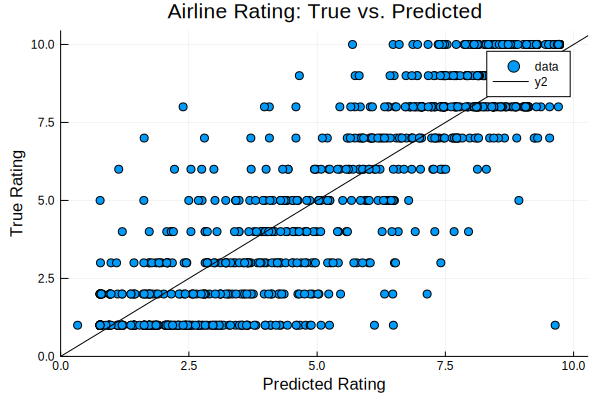

In [11]:
# Gather prediction for training and testing data sets
train_pred = train_vals_real*w
test_pred = test_vals_real*w

# Calculate MSE for each prediction (training and testing)
train_MSE = MSE(train_pred,train_y)
test_MSE = MSE(test_pred,test_y)

# println("SEAT COMFORT RATING and CABIN STAFF RATING")
# println("Train MSE:\t", train_MSE)
# println("Test MSE: \t", test_MSE)

println("SEAT COMFORT RATING, CABIN STAFF RATING, FOOD/BEVERAGE, INFLIGHT ENTERTAINMENT, VALUE MONEY RATING")
println("Train MSE:\t", train_MSE)
println("Test MSE: \t", test_MSE)

# Plot MSE plots
plot_pred_true(test_pred, test_y)
title!("Airline Rating: True vs. Predicted")

Difficult to visualize how accurate it is because many of the data points are completely on top of each other. Rating only goes from 0-10. If there's a way to use a color bar to see the density of each point would make things easier to visualize.

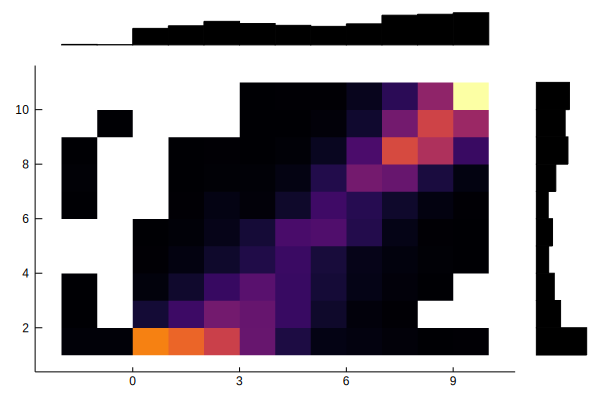

In [12]:
marginalhist(test_pred, test_y,bins=15)

Should try to cross validate data for future tests. For reason test error is less than training error. 

In [13]:
num_tests = 1000;
train_proportion = 0.8
w_array = zeros(6,num_tests)
train_MSE_array = zeros(num_tests)
test_MSE_array = zeros(num_tests)

for i = 1:num_tests
    # Shuffle the rows of airline data with excluded missing parameters
    data_OR_filtered = data_OR_filtered[shuffle(1:end),:];

    # Reallocate training and testing data sets
    n = size(data_OR_filtered, 1)

    # Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
    ntrain = convert(Int, round(train_proportion*n))
    target = data_OR_filtered[:, :overall_rating]

    # the following variable records the features of examples in the training set
    train_x = data_OR_filtered[1:ntrain,:]

    # the following variable records the features of examples in the test set
    test_x = data_OR_filtered[ntrain+1:end,:]

    # the following variable records the labels of examples in the training set
    train_y = target[1:ntrain]
    train_y = collect(skipmissing(train_y))
    # the following variable records the labels of examples in the test set
    test_y = target[ntrain+1:end]
    test_y = collect(skipmissing(test_y));
    
    # Only converting seat comfort and cabin staff rating
#     train_vals_real = convert(Matrix,train_x[:,filter(col -> (col in labels_real), [:seat_comfort_rating,:cabin_staff_rating])]);
#     test_vals_real = convert(Matrix,test_x[:,filter(col -> (col in labels_real), [:seat_comfort_rating,:cabin_staff_rating])]);

    
    # Only converting for seat comfort, cabin staff, food/beverage, and inflight entertainment
    train_vals_real = convert(Matrix,train_x[:,filter(col -> (col in labels_real), [:seat_comfort_rating,:cabin_staff_rating,:food_beverages_rating,:inflight_entertainment_rating,:value_money_rating])]);
    test_vals_real = convert(Matrix,test_x[:,filter(col -> (col in labels_real), [:seat_comfort_rating,:cabin_staff_rating,:food_beverages_rating,:inflight_entertainment_rating,:value_money_rating])]);

    # Add offset
    train_vals_real = [train_vals_real ones(size(train_vals_real,1))];
    test_vals_real = [test_vals_real ones(size(test_vals_real,1))];
    
    # Calculate w solution 
    w = train_vals_real\train_y
    
    # Gather prediction for training and testing data sets
    train_pred = train_vals_real*w
    test_pred = test_vals_real*w

    # Calculate MSE for each prediction (training and testing)
    train_MSE = MSE(train_pred,train_y)
    test_MSE = MSE(test_pred,test_y)
    
    w_array[:,i] = w
    train_MSE_array[i] = train_MSE
    test_MSE_array[i] = test_MSE
end

train_MSE_average = mean(train_MSE_array)
test_MSE_average = mean(test_MSE_array)
average_w = mean(w_array,dims=2)

[train_MSE_average test_MSE_average]

1×2 Array{Float64,2}:
 2.23642  2.23663

In [14]:
mean(w_array,dims=2)

6×1 Array{Float64,2}:
  0.4254384690797109  
  0.6619192054481483  
  0.16618150255469857 
  0.031703468711163675
  0.9759900340039981  
 -1.5582357368237503  

In [15]:
w_array

6×1000 Array{Float64,2}:
  0.429703    0.442731    0.421042   …   0.421592   0.413098    0.430857 
  0.663646    0.65612     0.654813       0.655166   0.659282    0.659765 
  0.166919    0.162258    0.176108       0.163243   0.157003    0.16179  
  0.0296062   0.0306551   0.0312017      0.034849   0.0373083   0.0354731
  0.973263    0.973758    0.979388       0.982346   0.978941    0.983885 
 -1.56892    -1.57445    -1.55479    …  -1.54482   -1.50676    -1.59139  

In [16]:
train_vals_real = convert(Array{Float64,2},train_vals_real)

22673×6 Array{Float64,2}:
 4.0  4.0  4.0  4.0  4.0  1.0
 5.0  5.0  5.0  5.0  5.0  1.0
 1.0  3.0  3.0  4.0  1.0  1.0
 2.0  4.0  3.0  3.0  3.0  1.0
 4.0  3.0  3.0  1.0  4.0  1.0
 4.0  5.0  4.0  4.0  5.0  1.0
 3.0  5.0  4.0  4.0  3.0  1.0
 3.0  4.0  0.0  0.0  3.0  1.0
 4.0  2.0  2.0  4.0  5.0  1.0
 5.0  5.0  5.0  1.0  5.0  1.0
 1.0  2.0  4.0  1.0  2.0  1.0
 4.0  5.0  4.0  4.0  5.0  1.0
 4.0  4.0  3.0  1.0  4.0  1.0
 ⋮                        ⋮  
 4.0  4.0  5.0  4.0  5.0  1.0
 4.0  5.0  5.0  0.0  4.0  1.0
 4.0  3.0  4.0  4.0  4.0  1.0
 4.0  4.0  3.0  4.0  4.0  1.0
 2.0  5.0  5.0  3.0  4.0  1.0
 5.0  5.0  5.0  5.0  5.0  1.0
 2.0  3.0  1.0  1.0  3.0  1.0
 1.0  1.0  1.0  1.0  2.0  1.0
 5.0  5.0  5.0  0.0  4.0  1.0
 5.0  5.0  5.0  0.0  4.0  1.0
 4.0  5.0  5.0  5.0  5.0  1.0
 5.0  3.0  2.0  3.0  5.0  1.0

In [17]:
# L1 Loss
loss_L1 = 1/n*L1Loss()
λ = 1
# Quad Regularizer
reg = λ*QuadReg()

w_L1 = proxgrad(loss_L1, reg, train_vals_real, train_y, maxiters=10)
train_pred = train_vals_real*w_L1
test_pred = test_vals_real*w_L1
train_MSE = MSE(train_pred,train_y)
test_MSE = MSE(test_pred,test_y)

println("Train MSE:\t", train_MSE)
println("Test MSE: \t", test_MSE)

Train MSE:	3.051803433077035
Test MSE: 	3.1089147335314777


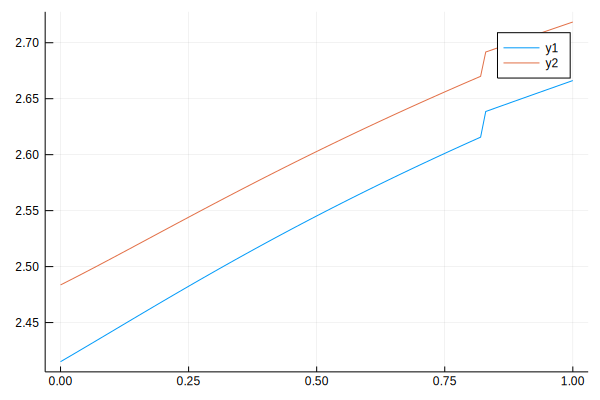

In [18]:
# L2 Loss
loss_L2 = 1/n*QuadLoss()
# Quad Regularizer
# reg = λ*QuadReg()
# reg = ZeroReg()

train_MSE_array = zeros(101)
test_MSE_array = zeros(101)

for i = 0:100

    λ = i/100
    reg = λ*QuadReg()
    w_L2 = proxgrad(loss_L2, reg, train_vals_real, train_y, maxiters=100)
    train_pred = train_vals_real*w_L2
    test_pred = test_vals_real*w_L2
    train_MSE = MSE(train_pred,train_y)
    test_MSE = MSE(test_pred,test_y)
    train_MSE_array[i+1] = train_MSE 
    test_MSE_array[i+1] = test_MSE
end

plot(collect(0:0.01:1),train_MSE_array)
plot!(collect(0:0.01:1),test_MSE_array)
# println("Train MSE:\t", train_MSE)
# println("Test MSE: \t", test_MSE)

In [ ]:
# L1 Loss
loss_L1 = 1/n*L1Loss()
# Quad Regularizer
# reg = λ*QuadReg()
# reg = ZeroReg()

train_MSE_array = zeros(101)
test_MSE_array = zeros(101)

for i = 0:100

    λ = i/100
    reg = λ*QuadReg()
    w_L1 = proxgrad(loss_L1, reg, train_vals_real, train_y, maxiters=10)
    train_pred = train_vals_real*w_L1
    test_pred = test_vals_real*w_L1
    train_MSE = MSE(train_pred,train_y)
    test_MSE = MSE(test_pred,test_y)
    train_MSE_array[i+1] = train_MSE 
    test_MSE_array[i+1] = test_MSE
end

plot(collect(0:0.01:1),train_MSE_array)
plot!(collect(0:0.01:1),test_MSE_array)
println("Train MSE:\t", min(train_MSE_array))
println("Test MSE: \t", test_MSE)

In [ ]:
min([3 2 1 3 46])